# Imports

In [27]:
import pathlib
from pathlib import Path
import sys

_here = Path().resolve().parent
# print(_here,str(_here))
sys.path.append(str(_here))


import os
import shutil
import warnings

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score   
import time

from typing import List, Dict, Union, Optional, Tuple
import torch
import torch.nn as nn
import torchcde
from torch.utils.data import Dataset, DataLoader

from src.data.transforms import insert_random_missingness, preprocess_for_transformer
from src.models.RNNModel import RNNModel
from src.models.LSTMModel import LSTMModel

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Setting model hyperparameters

In [36]:
HP = {
    'run_RNN' : True,
    'run_LSTM' : True,
    'missing_rate': 0.0,
    'batch_size': 32,
}

# Hyperparameters for the RNN model
RNNHP = {
    "input_dim": 5,
    "hidden_dim": 128,
    "layer_dim": 2,
    "output_dim": 20,
    "lr": 0.001,
    "epochs": 500,
    "patience": 100
}

# Hyperparameters for the LSTM model
LSTMHP = {
    "input_dim": 5,
    "hidden_dim": 128,
    "layer_dim": 2,
    "output_dim": 20,
    "lr": 0.001,
    "epochs": 500,
    "patience": 100
}

# Retrieving the data

In [29]:
CharacterTrajectoriesDataPath = str(_here) + "/data/processed/CharacterTrajectories/classification"

x_train = torch.load(CharacterTrajectoriesDataPath + "/X_train.pt").float()
y_train = torch.load(CharacterTrajectoriesDataPath + "/y_train.pt").long()
x_test = torch.load(CharacterTrajectoriesDataPath + "/X_test.pt").float() 
y_test = torch.load(CharacterTrajectoriesDataPath + "/y_test.pt").long()


### Preparing and Visualizing the data

In [30]:
# Insert random missingness and preprocessing data
x_train = insert_random_missingness(x_train, HP['missing_rate'])
x_test = insert_random_missingness(x_test, HP['missing_rate'])
x_train, _ = preprocess_for_transformer(x_train)
x_test, _ = preprocess_for_transformer(x_test)
x_train, x_test = x_train.to(device), x_test.to(device)

# x_train = torchcde.hermite_cubic_coefficients_with_backward_differences(x_train)
# x_train = torchcde.CubicSpline(x_train)

print(x_train.shape)
print(x_train[:5][:5][:])
print(y_train.shape)
print(torch.unique(y_train))

# Split train set into train and validation
val_size = int(0.2 * len(x_train))
x_train, x_val = x_train[:-val_size], x_train[-val_size:]
y_train, y_val = y_train[:-val_size], y_train[-val_size:]


torch.Size([2287, 182, 5])
tensor([[[ 0.0000e+00, -2.4946e-01,  1.9040e-01,  8.0642e-01,  1.0000e+00],
         [ 1.0000e+00, -3.3995e-01,  2.4208e-01,  1.0169e+00,  2.0000e+00],
         [ 2.0000e+00, -4.1913e-01,  2.7345e-01,  1.1379e+00,  3.0000e+00],
         ...,
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00]],

        [[ 0.0000e+00,  1.9631e-01,  1.0307e-01,  2.0588e-01,  1.0000e+00],
         [ 1.0000e+00,  2.2589e-01,  1.4365e-01,  2.9540e-01,  2.0000e+00],
         [ 2.0000e+00,  2.2073e-01,  1.8072e-01,  4.1466e-01,  3.0000e+00],
         ...,
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00]],

        [[ 0.0000e+00, -6.359

## helper method for getting the length of the given input

In [31]:
def getLenghts(inputs):
    # inputs is a tensor of size batch * 182 * 4
    # returns a list of size batch, indicating the true sequence length of each batch
    lengths = []
    for i in range(inputs.shape[0]):
        for j in range(1,inputs.shape[1]+1):
            if j == inputs.shape[1] or inputs[i][j][0] == 0:
                lengths.append(j)
                break

    return torch.tensor(lengths, dtype=torch.long).cpu()


## Initializing Datasets

In [32]:
class CharacterTrajectoriesDataset(Dataset):
    def __init__(self, x, y, get_lengths):
        self.x = x
        self.y = y
        self.get_lengths = get_lengths

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

    def collate_fn(batch):
        x, y = zip(*batch)
        x = torch.stack(x).to(device)
        lengths = getLenghts(x)
        y = torch.tensor(y).to(device)
        return x, y, lengths

train_dataset = CharacterTrajectoriesDataset(x_train, y_train, getLenghts)
val_dataset = CharacterTrajectoriesDataset(x_val, y_val, getLenghts)
test_dataset = CharacterTrajectoriesDataset(x_test, y_test, getLenghts)

train_loader = DataLoader(train_dataset, batch_size=HP['batch_size'], shuffle=True, collate_fn=CharacterTrajectoriesDataset.collate_fn)
val_loader = DataLoader(val_dataset, batch_size=HP['batch_size'], shuffle=True, collate_fn=CharacterTrajectoriesDataset.collate_fn)
test_loader = DataLoader(test_dataset, batch_size=HP['batch_size'], shuffle=False, collate_fn=CharacterTrajectoriesDataset.collate_fn)


# Train method

In [33]:
def train_model(model, train_loader, test_loader, criterion, optimizer, epochs=100, patience=100):
    best_val_acc = 0
    best_params = None
    patience_counter = 0
    
    # Lists to store per-epoch loss and accuracy
    train_losses = []
    eval_losses = []
    eval_accs = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for x_batch, y_batch, lengths in train_loader:
            optimizer.zero_grad()
            outputs = model(x_batch, lengths)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation phase
        model.eval()
        total_val_loss = 0
        total_correct = 0
        total_samples = 0
        with torch.no_grad():
            for x_batch, y_batch, lengths in test_loader:
                outputs = model(x_batch, lengths)
                loss = criterion(outputs, y_batch)
                total_val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total_correct += (predicted == y_batch).sum().item()
                total_samples += y_batch.size(0)

        avg_val_loss = total_val_loss / len(test_loader)
        val_accuracy = total_correct / total_samples

        eval_losses.append(avg_val_loss)
        eval_accs.append(val_accuracy)

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}')
        
        # Early Stopping Check
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            patience_counter = 0
            best_params = model.state_dict()
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Stopping early due to no improvement in validation Acc.")
            break

    model.load_state_dict(best_params)

    return train_losses, eval_losses, eval_accs

def evaluate(model, test_dataloader):
    model.eval()
    with torch.no_grad():
        total_correct = 0
        total_samples = 0

        for x_batch, y_batch, lengths in test_loader:
                outputs = model(x_batch, lengths)
                _, predicted = torch.max(outputs, 1)
                total_correct += (predicted == y_batch).sum().item()
                total_samples += y_batch.size(0)

        val_accuracy = total_correct / total_samples


        print(f'Test accuracy: {val_accuracy}')

    return val_accuracy


In [34]:
def plot_learning_curves(train_losses, eval_losses, eval_accs, title='Learning Curves'):
    # Extract the data for plotting
    iterations = list(range(1, len(train_losses) + 1))

    # Plot training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(iterations, train_losses, 'r-', label='Training Loss')
    plt.plot(iterations, eval_losses, 'b-', label='Validation Loss')
    plt.xlabel('Training Iterations')
    plt.ylabel('Loss')
    plt.title(title + ' - Loss')
    plt.legend(loc='upper left')
    plt.savefig(title + '_loss.png')  # Save the plot as a PNG file
    plt.show()

    # Plot validation accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(iterations, eval_accs, 'g-', label='Validation Accuracy')
    plt.xlabel('Training Iterations')
    plt.ylabel('Accuracy (%)')
    plt.title(title + ' - Accuracy')
    plt.legend(loc='upper left')
    plt.savefig(title + '_accuracy.png')  # Save the plot as a PNG file
    plt.show()



# Training

RNN Total number of parameters: 52884
Epoch 1/500, Train Loss: 2.8714, Val Loss: 2.5997, Val Acc: 0.1357
Epoch 2/500, Train Loss: 2.4768, Val Loss: 2.3928, Val Acc: 0.2166
Epoch 3/500, Train Loss: 2.3863, Val Loss: 2.2808, Val Acc: 0.2429
Epoch 4/500, Train Loss: 2.2790, Val Loss: 2.2459, Val Acc: 0.2560
Epoch 5/500, Train Loss: 2.1128, Val Loss: 2.1203, Val Acc: 0.2932
Epoch 6/500, Train Loss: 2.3480, Val Loss: 2.2715, Val Acc: 0.2626
Epoch 7/500, Train Loss: 2.1046, Val Loss: 1.9166, Val Acc: 0.3479
Epoch 8/500, Train Loss: 1.9844, Val Loss: 1.8593, Val Acc: 0.3654
Epoch 9/500, Train Loss: 2.0698, Val Loss: 1.9445, Val Acc: 0.3720
Epoch 10/500, Train Loss: 2.3481, Val Loss: 2.3968, Val Acc: 0.2013
Epoch 11/500, Train Loss: 2.3645, Val Loss: 2.3439, Val Acc: 0.2210
Epoch 12/500, Train Loss: 2.3311, Val Loss: 2.2202, Val Acc: 0.2560
Epoch 13/500, Train Loss: 2.3052, Val Loss: 2.3346, Val Acc: 0.1991
Epoch 14/500, Train Loss: 2.2478, Val Loss: 2.3169, Val Acc: 0.2123
Epoch 15/500, Train

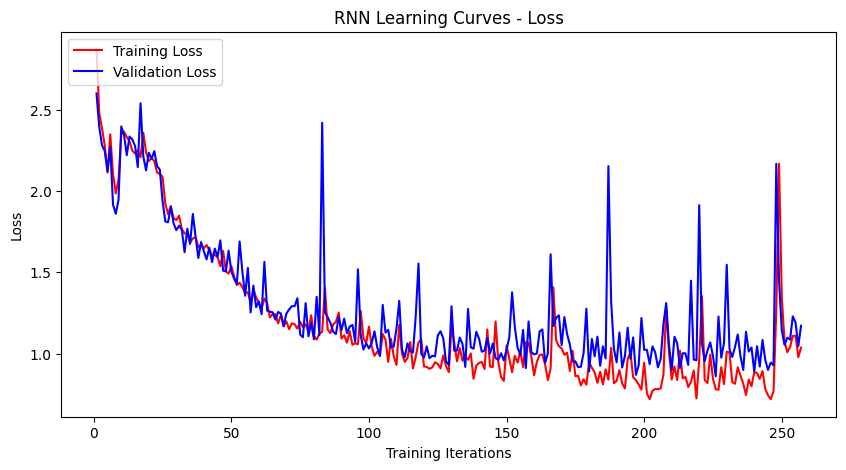

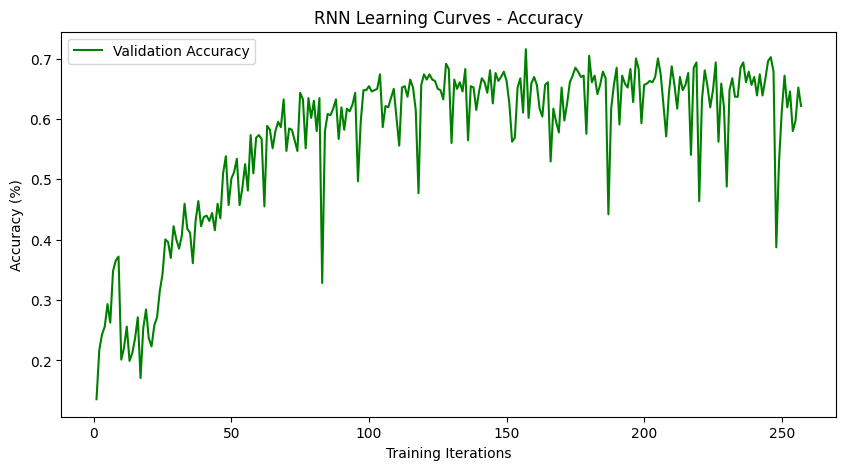

Test accuracy: 0.6234676007005254


In [37]:
if HP['run_RNN']:

        # Create the RNN model
        model = RNNModel(RNNHP["input_dim"], RNNHP["hidden_dim"], RNNHP["layer_dim"], RNNHP["output_dim"]).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=RNNHP["lr"])
        total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"RNN Total number of parameters: {total_params}")

        # Train the RNN model
        train_losses, eval_losses, eval_accs = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=RNNHP["epochs"], patience=RNNHP["patience"])
        plot_learning_curves(train_losses, eval_losses, eval_accs, "RNN Learning Curves")
        evaluate(model, test_loader)




## LSTM training

LSTM Total number of parameters: 203796
Epoch 1/500, Train Loss: 2.7498, Val Loss: 2.5946, Val Acc: 0.1729
Epoch 2/500, Train Loss: 2.3804, Val Loss: 2.3625, Val Acc: 0.2319
Epoch 3/500, Train Loss: 2.3093, Val Loss: 2.3639, Val Acc: 0.2123
Epoch 4/500, Train Loss: 2.2510, Val Loss: 2.2258, Val Acc: 0.2626
Epoch 5/500, Train Loss: 2.2083, Val Loss: 2.1677, Val Acc: 0.2801
Epoch 6/500, Train Loss: 2.2284, Val Loss: 2.1343, Val Acc: 0.2823
Epoch 7/500, Train Loss: 2.2305, Val Loss: 2.2145, Val Acc: 0.2254
Epoch 8/500, Train Loss: 2.0767, Val Loss: 1.9925, Val Acc: 0.3217
Epoch 9/500, Train Loss: 1.9256, Val Loss: 1.7657, Val Acc: 0.3786
Epoch 10/500, Train Loss: 1.6654, Val Loss: 1.5916, Val Acc: 0.4354
Epoch 11/500, Train Loss: 1.4129, Val Loss: 1.3648, Val Acc: 0.5405
Epoch 12/500, Train Loss: 1.0610, Val Loss: 0.8930, Val Acc: 0.7199
Epoch 13/500, Train Loss: 0.9425, Val Loss: 0.8848, Val Acc: 0.7046
Epoch 14/500, Train Loss: 1.0118, Val Loss: 0.9110, Val Acc: 0.6718
Epoch 15/500, Tra

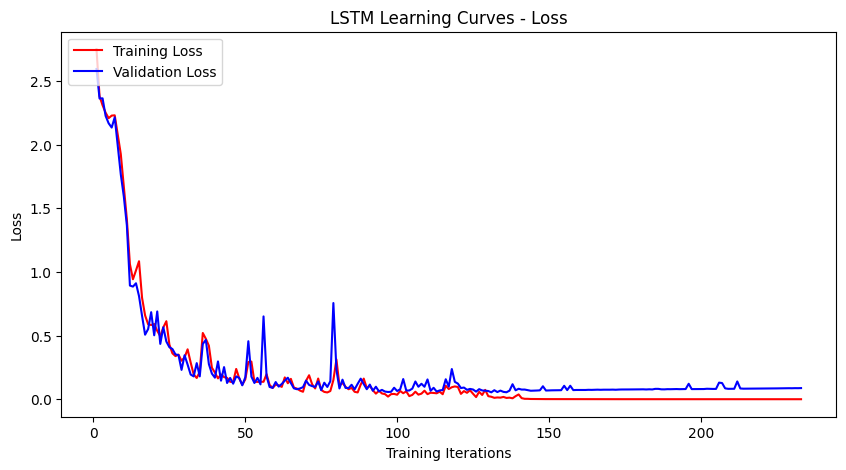

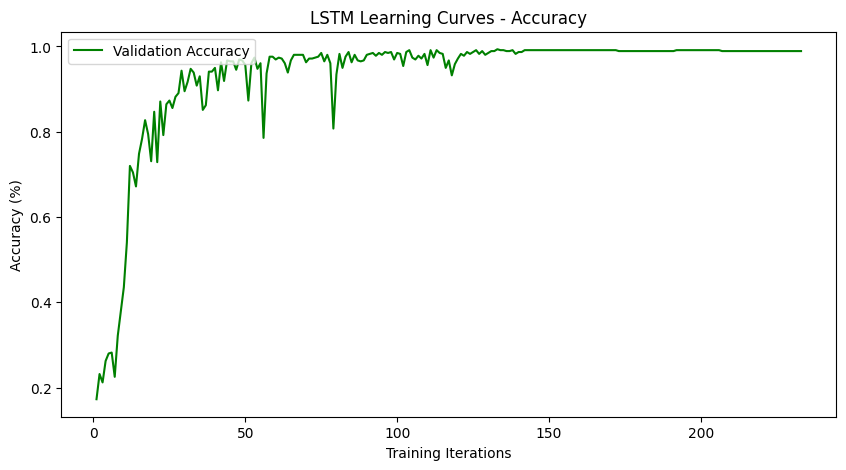

Test accuracy: 0.9912434325744308


In [38]:
if HP['run_LSTM']:
        # Create the LSTM model
        model = LSTMModel(LSTMHP["input_dim"], LSTMHP["hidden_dim"], LSTMHP["layer_dim"], LSTMHP["output_dim"]).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=LSTMHP["lr"])
        total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"LSTM Total number of parameters: {total_params}")
        # Train the LSTM model
        train_losses, eval_losses, eval_accs = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=LSTMHP["epochs"], patience=LSTMHP["patience"])
        plot_learning_curves(train_losses, eval_losses, eval_accs, "LSTM Learning Curves")
        evaluate(model, test_loader)